In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

# Load provider-level dataset created in Notebook 1
df = pd.read_csv('/content/provider_featuress.csv')
df.head()

,Provider,PotentialFraud,n_inpt_claims,n_inpt_bene,inpt_total_reimb,inpt_mean_reimb,inpt_max_reimb,inpt_min_reimb,n_outpt_claims,n_outpt_bene,...,ChronicCond_Heartfailure_rate,ChronicCond_KidneyDisease_rate,ChronicCond_Cancer_rate,ChronicCond_ObstrPulmonary_rate,ChronicCond_Depression_rate,ChronicCond_Diabetes_rate,ChronicCond_IschemicHeart_rate,ChronicCond_Osteoporasis_rate,ChronicCond_rheumatoidarthritis_rate,ChronicCond_stroke_rate
0,PRV51001,No,5.0,5.0,97000.0,19400.000000,42000.0,3000.0,20.0,19.0,...,1.200000,1.200000,1.800000,1.600000,1.200000,1.200000,1.200000,2.000000,1.400000,1.600000
1,PRV51003,Yes,62.0,53.0,573000.0,9241.935484,57000.0,0.0,70.0,66.0,...,1.419355,1.370968,1.887097,1.629032,1.596774,1.209677,1.112903,1.790323,1.693548,1.887097
2,PRV51004,No,0.0,0.0,0.0,0.000000,0.0,0.0,149.0,138.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,PRV51005,Yes,0.0,0.0,0.0,0.000000,0.0,0.0,1165.0,495.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,PRV51007,No,3.0,3.0,19000.0,6333.333333,10000.0,3000.0,69.0,56.0,...,1.000000,1.666667,2.000000,2.000000,1.333333,1.000000,1.000000,2.000000,1.666667,1.333333


In [3]:
# Convert Fraud Yes/No → 1/0
df['Fraud'] = (df['PotentialFraud'] == 'Yes').astype(int)

# Drop columns not used for modeling
X = df.drop(columns=['Provider', 'PotentialFraud', 'Fraud'])
y = df['Fraud']

X.shape, y.shape

((5410, 33), (5410,))

In [4]:
# First split: train+val vs test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Second split: train vs validation
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25, stratify=y_trainval, random_state=42
)

X_train.shape, X_val.shape, X_test.shape

((3246, 33), (1082, 33), (1082, 33))

In [5]:
log_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

log_reg.fit(X_train, y_train)

# Probabilities and predictions
val_probs_lr = log_reg.predict_proba(X_val)[:, 1]
val_pred_lr = (val_probs_lr >= 0.5).astype(int)

print("=== Logistic Regression Validation Report ===")
print(classification_report(y_val, val_pred_lr))
print("ROC-AUC:", roc_auc_score(y_val, val_probs_lr))
print("PR-AUC:", average_precision_score(y_val, val_probs_lr))

=== Logistic Regression Validation Report ===
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       981
           1       0.42      0.80      0.55       101

    accuracy                           0.88      1082
   macro avg       0.70      0.84      0.74      1082
weighted avg       0.92      0.88      0.89      1082

ROC-AUC: 0.917703696975202
PR-AUC: 0.6151993890601092


In [6]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

val_probs_rf = rf.predict_proba(X_val)[:, 1]
val_pred_rf = (val_probs_rf >= 0.5).astype(int)

print("=== Random Forest Validation Report ===")
print(classification_report(y_val, val_pred_rf))
print("ROC-AUC:", roc_auc_score(y_val, val_probs_rf))
print("PR-AUC:", average_precision_score(y_val, val_probs_rf))

=== Random Forest Validation Report ===
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       981
           1       0.61      0.33      0.43       101

    accuracy                           0.92      1082
   macro avg       0.77      0.65      0.69      1082
weighted avg       0.90      0.92      0.91      1082

ROC-AUC: 0.9098212573550932
PR-AUC: 0.5687923945192264


In [7]:
gb = GradientBoostingClassifier(random_state=42)

gb.fit(X_train, y_train)

val_probs_gb = gb.predict_proba(X_val)[:, 1]
val_pred_gb = (val_probs_gb >= 0.5).astype(int)

print("=== Gradient Boosting Validation Report ===")
print(classification_report(y_val, val_pred_gb))
print("ROC-AUC:", roc_auc_score(y_val, val_probs_gb))
print("PR-AUC:", average_precision_score(y_val, val_probs_gb))

=== Gradient Boosting Validation Report ===
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       981
           1       0.70      0.44      0.54       101

    accuracy                           0.93      1082
   macro avg       0.82      0.71      0.75      1082
weighted avg       0.92      0.93      0.92      1082

ROC-AUC: 0.9216449167852564
PR-AUC: 0.6530410665273177


In [8]:
model_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
roc_values = [
    roc_auc_score(y_val, val_probs_lr),
    roc_auc_score(y_val, val_probs_rf),
    roc_auc_score(y_val, val_probs_gb)
]
pr_values = [
    average_precision_score(y_val, val_probs_lr),
    average_precision_score(y_val, val_probs_rf),
    average_precision_score(y_val, val_probs_gb)
]

metrics_df = pd.DataFrame({
    'Model': model_names,
    'ROC-AUC': roc_values,
    'PR-AUC': pr_values
})

metrics_df

,Model,ROC-AUC,PR-AUC
0,Logistic Regression,0.917704,0.615199
1,Random Forest,0.909821,0.568792
2,Gradient Boosting,0.921645,0.653041


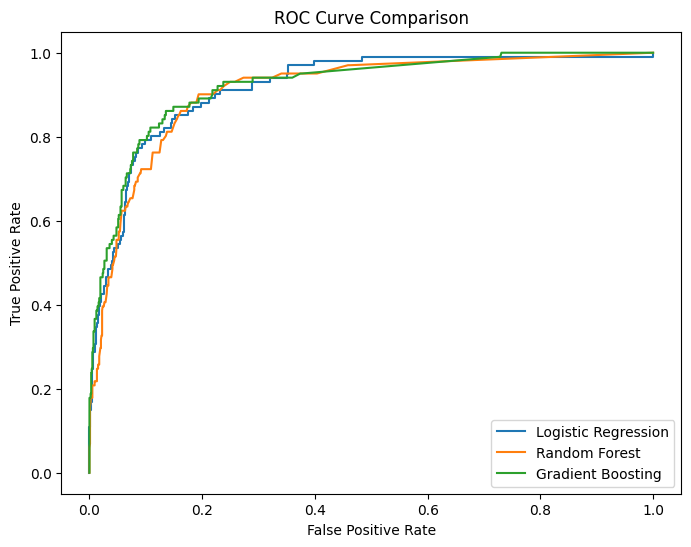

In [9]:
plt.figure(figsize=(8, 6))

fpr_lr, tpr_lr, _ = roc_curve(y_val, val_probs_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, val_probs_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_val, val_probs_gb)

plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

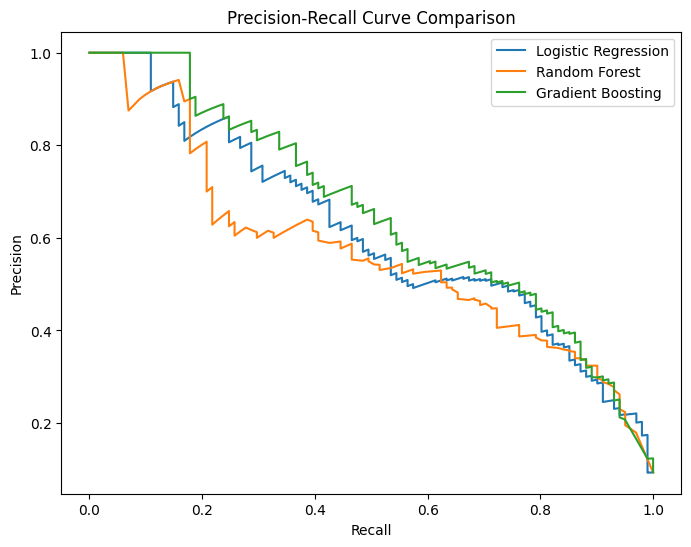

In [10]:
plt.figure(figsize=(8, 6))

prec_lr, rec_lr, _ = precision_recall_curve(y_val, val_probs_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_val, val_probs_rf)
prec_gb, rec_gb, _ = precision_recall_curve(y_val, val_probs_gb)

plt.plot(rec_lr, prec_lr, label='Logistic Regression')
plt.plot(rec_rf, prec_rf, label='Random Forest')
plt.plot(rec_gb, prec_gb, label='Gradient Boosting')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()

In [11]:
thresholds = np.arange(0.1, 0.91, 0.05)

print("Threshold | Precision | Recall | F1")
for t in thresholds:
    pred_t = (val_probs_rf >= t).astype(int)
    prec = precision_score(y_val, pred_t)
    rec = recall_score(y_val, pred_t)
    f1 = f1_score(y_val, pred_t)
    print(f"{t:.2f}      | {prec:.3f}     | {rec:.3f}  | {f1:.3f}")

Threshold | Precision | Recall | F1
0.10      | 0.357     | 0.851  | 0.503
0.15      | 0.435     | 0.723  | 0.543
0.20      | 0.489     | 0.644  | 0.556
0.25      | 0.521     | 0.624  | 0.568
0.30      | 0.535     | 0.535  | 0.535
0.35      | 0.560     | 0.465  | 0.508
0.40      | 0.592     | 0.416  | 0.488
0.45      | 0.635     | 0.396  | 0.488
0.50      | 0.611     | 0.327  | 0.426
0.55      | 0.617     | 0.287  | 0.392
0.60      | 0.619     | 0.257  | 0.364
0.65      | 0.629     | 0.218  | 0.324
0.70      | 0.710     | 0.218  | 0.333
0.75      | 0.800     | 0.198  | 0.317
0.80      | 0.895     | 0.168  | 0.283
0.85      | 0.929     | 0.129  | 0.226
0.90      | 0.875     | 0.069  | 0.128


In [12]:
best_threshold = 0.35
best_model = rf

# Retrain on full train+validation
best_model.fit(X_trainval, y_trainval)

RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)

In [13]:
test_probs = best_model.predict_proba(X_test)[:, 1]
test_pred = (test_probs >= best_threshold).astype(int)

print("=== Final Test Set Evaluation ===")
print(classification_report(y_test, test_pred))
print("ROC-AUC:", roc_auc_score(y_test, test_probs))
print("PR-AUC:", average_precision_score(y_test, test_probs))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, test_pred))

=== Final Test Set Evaluation ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       981
           1       0.66      0.66      0.66       101

    accuracy                           0.94      1082
   macro avg       0.81      0.81      0.81      1082
weighted avg       0.94      0.94      0.94      1082

ROC-AUC: 0.9485824729261917
PR-AUC: 0.7266907280948685

Confusion Matrix:
[[947  34]
 [ 34  67]]


### Notebook 2 Summary — Modeling

In this notebook, we:
- Prepared provider-level features for modeling.
- Split data into train/validation/test.
- Handled class imbalance using class-weight.
- Built baseline Logistic Regression model.
- Built two advanced models: Random Forest and Gradient Boosting.
- Compared models using ROC-AUC and PR-AUC.
- Tuned decision threshold to optimize recall vs precision.
- Selected the best model (Random Forest).
- Evaluated final model on the test set.
